In [1]:
from google.colab import drive
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
input_data = np.load('/content/drive/My Drive/Data Arrays/ATLASX_uint8.npy')
input_label = np.load('/content/drive/My Drive/Data Arrays/ATLASY_uint8.npy')

In [4]:
inp_data = []
inp_label = []
for i in range(len(input_label)):
    r = np.sum(input_label[i]) / input_label[i].size
    if r > 0.05:
        inp_data.append(input_data[i].copy())
        inp_label.append(input_label[i].copy())


inp_data = np.array(inp_data)
inp_label = np.array(inp_label)

In [5]:
images = inp_data / 255.0
masks = inp_label

In [6]:
images.shape

(2183, 256, 256, 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Loss Functions


In [8]:
class Custom_CE_Loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        log_y_pred = tf.math.log(y_pred)
        elements = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
        return tf.reduce_mean(tf.reduce_sum(elements,axis=1))

In [9]:
def soft_n_cut_loss_single_k(weights, enc, batch_size, img_size, radius=5):
    channels = 1
    h, w = img_size
    p = radius

    kh, kw = radius*2 + 1, radius*2 + 1
    dh, dw = 1, 1
    encoding = F.pad(input=enc, pad=(p, p, p, p), mode='constant', value=0)

    seg = encoding.unfold(2, kh, dh).unfold(3, kw, dw)
    seg = seg.contiguous().view(batch_size, channels, -1, kh, kw)
    seg = seg.permute(0, 2, 1, 3, 4)
    seg = seg.view(-1, channels, kh, kw)

    nom = weights * seg

    nominator = torch.sum(enc * torch.sum(nom, dim=(1,2,3)).reshape(batch_size, h, w), dim=(1,2,3))
    denominator = torch.sum(enc * torch.sum(weights, dim=(1,2,3)).reshape(batch_size, h, w), dim=(1,2,3))

    return torch.div(nominator, denominator)

In [57]:
import numpy as np
from skimage import color
from sklearn.cluster import KMeans

def compute_soft_ncut_loss(image1, image2, patch_size=(16, 16), stride=(8, 8), k=2):

    image1_gray = np.array(image1)
    image2_gray = np.array(image2)

    rows = np.arange(0, image1_gray.shape[0] - patch_size[0] + 1, stride[0])
    cols = np.arange(0, image1_gray.shape[1] - patch_size[1] + 1, stride[1])

    num_patches = len(rows) * len(cols)
    similarity_matrix = np.zeros((num_patches, num_patches))

    patch_idx = 0
    for i in rows:
        for j in cols:
            patch1 = image1_gray[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patch_idx2 = 0
            for k in rows:
                for l in cols:
                    patch2 = image2_gray[k:k+patch_size[0], l:l+patch_size[1]].flatten()
                    similarity_matrix[patch_idx, patch_idx2] = np.exp(-np.sum(np.square(patch1 - patch2)))
                    patch_idx2 += 1
            patch_idx += 1

    degree_matrix = np.diag(np.sum(similarity_matrix, axis=1))
    laplacian_matrix = degree_matrix - similarity_matrix

    _, eigenvectors = np.linalg.eigh(laplacian_matrix)

    kmeans = KMeans(n_clusters=k)
    kmeans.fit(eigenvectors[:, 1:k])

    cluster_assignments = kmeans.labels_
    soft_ncut_loss = np.sum(similarity_matrix * (cluster_assignments[:, None] != cluster_assignments[None, :])) / np.sum(similarity_matrix)

    return soft_ncut_loss

# Example usage


In [53]:
def normalize_output(array1):

  result = [[0 for i in range(len(array1[0]))] for j in range(len(array1))]
  for i in range(len(array1)):
      for j in range(len(array1[i])):
          mx = 0
          for k in range(1):
              if array1[i][j][k] > array1[i][j][mx]:
                  mx = k
          result[i][j] = mx
  result = np.array(result)
  return result

# Model Generation


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.Conv2D(128, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv4))
    merge5 = layers.concatenate([conv3, up5], axis=3)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2D(64, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = layers.concatenate([conv2, up6], axis=3)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(32, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv1, up7], axis=3)
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv7)

    conv8 = layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    model = models.Model(inputs, conv8)

    return model

def wnet_model(input_size=(256, 256, 1)):
    # First U-Net
    unet1 = unet_model(input_size)

    inputs = layers.Input(input_size)
    unet1_output = unet1(inputs)

    # Second U-Net
    unet2 = unet_model(input_size)
    unet2_output = unet2(unet1_output)

    model = models.Model(inputs, unet2_output)

    return model


wnet_model = wnet_model()
wnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

wnet_model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 model_6 (Functional)        (None, 256, 256, 1)       1925025   
                                                                 
 model_7 (Functional)        (None, 256, 256, 1)       1925025   
                                                                 
Total params: 3850050 (14.69 MB)
Trainable params: 3850050 (14.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Initialize the loss function, optimizer, and metrics

import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import Mean


epochs = 10
batch_size = 8
# Convert the training and testing data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)


loss_fn = BinaryCrossentropy()
optimizer = Adam()
train_loss = Mean(name='train_loss')
val_loss = Mean(name='val_loss')

for epoch in range(epochs):
    print(f'Start of epoch {epoch + 1}')
    ncut_l = 0
    # Training loop
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        obj = np.expand_dims(x_batch_train[0], axis=0)
        with tf.GradientTape() as tape:
            logits = wnet_model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
            with tape.stop_recording():
              output = wnet_model.predict(obj)[0]
              output = normalize_output(output)
            temp = compute_soft_ncut_loss(output, y_batch_train[0])
            ncut_l += temp
            temp_tensor = tf.convert_to_tensor(temp, dtype=loss_value.dtype)
            loss_value += temp_tensor

        grads = tape.gradient(loss_value, wnet_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, wnet_model.trainable_weights))
        train_loss(loss_value)
    ncut_l /= (step + 1)

    for x_batch_val, y_batch_val in val_dataset:
        val_logits = wnet_model(x_batch_val, training=False)
        val_loss_value = loss_fn(y_batch_val, val_logits)
        val_loss(val_loss_value)

    print(f'Epoch {epoch + 1}, Loss: {train_loss.result()}, N-Cut Loss: {ncut_l}, Val Loss: {val_loss.result()}')

    train_loss.reset_states()
    val_loss.reset_states()


Start of epoch 1
1/1 [==============================] - 0s 45ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
wnet_model.save('/content/drive/My Drive/wnet_model_atlasx.h5')

# Testing


In [66]:
from tensorflow.keras.models import load_model
wnet_model = load_model('/content/drive/My Drive/wnet_model_atlas.h5')
wnet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 model (Functional)          (None, 256, 256, 1)       1925025   
                                                                 
 model_1 (Functional)        (None, 256, 256, 1)       1925025   
                                                                 
Total params: 3850050 (14.69 MB)
Trainable params: 3850050 (14.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


(256, 256, 1)
1/1 [==============================] - 0s 305ms/step


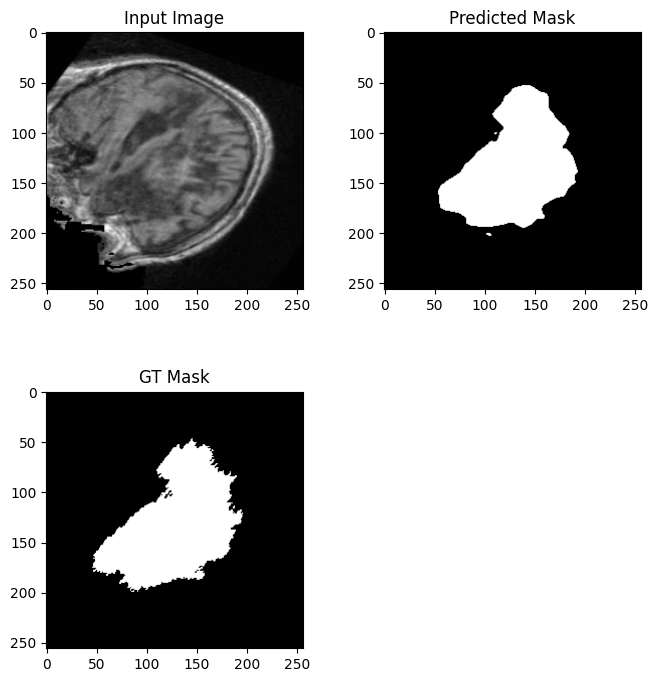

In [67]:
id = 300

img = images[id]
lbl = masks[id]
print(img.shape)
pred = wnet_model.predict(np.expand_dims(img, axis=0))[0]  # Model expects input in batch format

pred[pred < 0.5] = 0
pred[pred >= 0.5] = 1

plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Input Image')

plt.subplot(2, 2, 2)
plt.imshow(pred, cmap='gray')
plt.title('Predicted Mask')

plt.subplot(2, 2, 3)
plt.imshow(lbl, cmap='gray')
plt.title('GT Mask')

# Adjust the vertical spacing
plt.subplots_adjust(hspace=0.4)

plt.show()

In [24]:
predictions = wnet_model.predict(X_test)
ground_truth = y_test

predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

def compute_iou(pred, gt):
    # Flatten the arrays
    pred_flat = pred.flatten()
    gt_flat = gt.flatten()

    # Calculate intersection and union
    intersection = np.sum((pred_flat == 1) & (gt_flat == 1))
    union = np.sum((pred_flat == 1) | (gt_flat == 1))

    # Compute IoU
    if union == 0:
        return 0.0
    else:
        return intersection / union

# Calculate IoU for each pair of predicted and ground truth mask
ious = []
for i in range(predictions.shape[0]):
    iou = compute_iou(predictions[i], ground_truth[i])
    ious.append(iou)

# Compute the average IoU
average_iou = np.mean(ious)

print(f"Average IoU: {average_iou}")

14/14 [==============================] - 4s 313ms/step
Average IoU: 0.8158375461267559


# AIIMS Dataset


In [ ]:
pip install nibabel


In [ ]:
import nibabel as nib
import numpy as np

# Load the NIfTI file
nifti_file = 'ss_anita_1.nii.gz'
img = nib.load(nifti_file)

data = img.get_fdata()
data_normalized = data
# Normalize the data to the range [0, 1]
data_min = np.min(data)
data_max = np.max(data)
data_normalized = (data - data_min) / (data_max - data_min)

# Print the shape and data type of the normalized data
print("Shape of the data (normalized):", data_normalized.shape)
print("Data type (normalized):", data_normalized.dtype)
print("Min value (normalized):", np.min(data_normalized))
print("Max value (normalized):", np.max(data_normalized))

# Convert to uint8
# data_uint8 = data_normalized.astype(np.uint8)

# # Print the shape and data type of the uint8 data
# print("Shape of the data (uint8):", data_uint8.shape)
# print("Data type (uint8):", data_uint8.dtype)
# print("Min value (uint8):", np.min(data_uint8))
# print("Max value (uint8):", np.max(data_uint8))

Shape of the data (normalized): (256, 256, 256)
Data type (normalized): float64
Min value (normalized): 0.0
Max value (normalized): 1.0


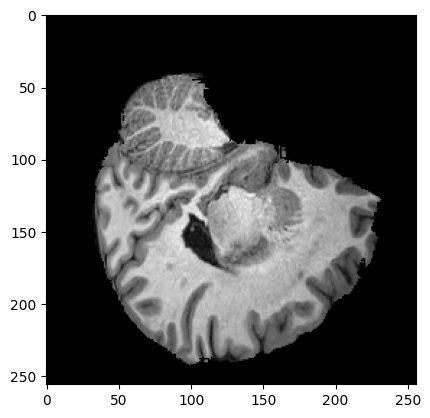

In [ ]:
plt.imshow(data_normalized[100],cmap = 'gray')

In [ ]:
start_id = 0
end_id = 255
lesion = 0

for idd in range(start_id, end_id + 1):
  img = data_normalized[idd]
  img = np.reshape(img, (256, 256, 1))
  # print(img.shape)
  pred = model.predict(np.expand_dims(img, axis=0))[0]  # Model expects input in batch format

  pred[pred < 0.5] = 0
  pred[pred >= 0.5] = 1
  lesion += np.sum(pred)

  # plt.figure(figsize=(8,8))
  # plt.subplot(2, 2, 1)
  # plt.imshow(img, cmap='gray')
  # plt.title('Input Image ' + str (idd) )

  # plt.subplot(2, 2, 2)
  # plt.imshow(pred, cmap='gray')
  # plt.title('Predicted Mask')

  # # Adjust the vertical spacing
  # plt.subplots_adjust(hspace=0.4)

  # plt.show()

1/1 [==============================] - 0s 25ms/step


In [ ]:
img = nib.load(nifti_file)

voxel_dims = img.header.get_zooms()
# print(voxel_dims)
voxel_volume = np.prod(voxel_dims)  # Calculate the volume of a single voxel
# print(voxel_volume)

# Calculate the total brain volume
lesion_volume = lesion * voxel_volume

print(f"Lesion volume: {lesion_volume} cubic millimeters")

Lesion volume: 8898.0 cubic millimeters
